In [1]:
# !pip install timeseries-cv
# !pip install pyunlocbox -qqq
# !pip install pygsp -qqq

from graph_learning_algorithm import learn_connected_graph, LapInv
import numpy as np
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet, MultiTaskElasticNetCV, MultiTaskLassoCV, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor
import scipy
from sklearn.covariance import graphical_lasso
from collections import defaultdict
from tsxv.splitTrain import split_train, split_train_variableInput
import itertools
from tqdm.notebook import tqdm
from dask.distributed import Client
import copy
from learn_graph_kalofolias import log_degree_barrier, l2_degree_reg
from backtesting import *
client = Client(processes=False)
client

Client Scheduler: inproc://192.168.1.5/11892/1 Dashboard: http://192.168.1.5:8787/status,Cluster Workers: 1 Cores: 12 Memory: 15.37 GiB


# Load Data

In [2]:
prices = pd.read_csv("data/sp500_prices_long.csv", parse_dates=['Date'])
prices['month'] = prices['Date'].dt.month
prices['year'] = prices['Date'].dt.year

In [3]:
raw_monthly_prices = prices.groupby(['year', 'month']).last().reset_index()
raw_monthly_prices['year_month'] = raw_monthly_prices['year'].astype(str) + ('00' + raw_monthly_prices['month'].astype(str)).str[-2:]
raw_monthly_prices = raw_monthly_prices.set_index('year_month').drop(columns=['year', 'month', 'Date'])

In [4]:
monthly_prices = raw_monthly_prices.loc[:, raw_monthly_prices.isna().mean(axis=0) < .5]
monthly_log_returns = np.log2(monthly_prices).diff().iloc[1:]#.shift(-1).iloc[:-1]
monthly_log_returns

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,WST,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
year_month,,,,,,,,,,,,,,,,,,,,,
199502,NaN,NaN,NaN,-0.027647,NaN,0.637430,0.005089,NaN,0.305002,0.224788,...,-0.054447,0.105554,NaN,-0.031535,0.048742,-0.074000,NaN,NaN,-0.137053,0.083523
199503,NaN,NaN,NaN,-0.164231,NaN,-0.271302,0.010125,NaN,0.470922,0.021373,...,-0.028016,-0.067957,NaN,-0.040414,0.060813,0.066775,NaN,NaN,0.172677,-0.072383
199504,NaN,NaN,NaN,0.117837,NaN,0.271302,0.147305,NaN,0.234830,0.075767,...,0.141296,0.111547,NaN,0.029978,0.060949,0.020611,NaN,NaN,0.162084,0.175223
199505,NaN,NaN,NaN,0.123818,0.040190,-0.041820,0.022720,NaN,-0.163747,0.211809,...,0.006427,0.076815,NaN,0.098448,0.053700,0.030374,NaN,NaN,-0.027783,0.086218
199506,NaN,NaN,NaN,0.160009,0.003958,0.021062,0.017922,NaN,0.157541,0.127462,...,-0.006427,0.103094,NaN,-0.038577,-0.015239,0.003030,NaN,NaN,0.242856,0.154145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202206,-0.103006,-0.494985,-0.120798,-0.122538,-0.129714,-0.091411,-0.112481,-0.104270,-0.186167,-0.205035,...,-0.037721,-0.248156,-0.214195,-0.080151,-0.164750,-0.141822,-0.097781,-0.191086,-0.202263,-0.164308
202207,0.177692,0.112674,0.161706,0.249304,0.044678,0.243463,0.008919,0.146612,0.163966,0.235216,...,0.185137,0.133062,0.155847,0.048515,0.178658,0.017259,0.110433,0.071396,0.283139,0.099914
202208,-0.064350,-0.077827,-0.199281,-0.045741,0.010699,-0.176439,-0.084475,-0.086386,-0.135170,-0.175543,...,-0.211606,-0.088456,-0.067222,0.020942,-0.006134,-0.142019,-0.132521,-0.054197,-0.245882,0.022701


# Load the factors and evaluate residuals

In [5]:
factors = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=2)
factors = factors[factors['Date'].astype(str).str.strip().str.len() == 6]
factors = factors.set_index('Date')
factors.columns += '_factor'
factors = factors.astype(np.float64)
factors

,Mkt-RF_factor,SMB_factor,HML_factor,RMW_factor,CMA_factor,RF_factor
Date,,,,,,
196307,-0.39,-0.41,-0.97,0.68,-1.18,0.27
196308,5.07,-0.80,1.80,0.36,-0.35,0.25
196309,-1.57,-0.52,0.13,-0.71,0.29,0.27
196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
196311,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
202205,-0.34,-0.06,8.41,1.44,3.98,0.03
202206,-8.43,1.30,-5.97,1.85,-4.70,0.06
202207,9.57,1.88,-4.10,0.68,-6.94,0.08


In [6]:
returns_factors_merged = monthly_log_returns.merge(factors, right_index=True, left_index=True, suffixes=['', '_factor'])
returns_factors_merged

,A,AAL,AAP,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,...,YUM,ZBH,ZBRA,ZION,Mkt-RF_factor,SMB_factor,HML_factor,RMW_factor,CMA_factor,RF_factor
199502,NaN,NaN,NaN,-0.027647,NaN,0.637430,0.005089,NaN,0.305002,0.224788,...,NaN,NaN,-0.137053,0.083523,3.63,-0.54,1.08,0.59,-0.33,0.40
199503,NaN,NaN,NaN,-0.164231,NaN,-0.271302,0.010125,NaN,0.470922,0.021373,...,NaN,NaN,0.172677,-0.072383,2.19,-0.51,-2.15,-0.17,0.22,0.46
199504,NaN,NaN,NaN,0.117837,NaN,0.271302,0.147305,NaN,0.234830,0.075767,...,NaN,NaN,0.162084,0.175223,2.11,-0.22,1.71,0.41,0.90,0.44
199505,NaN,NaN,NaN,0.123818,0.040190,-0.041820,0.022720,NaN,-0.163747,0.211809,...,NaN,NaN,-0.027783,0.086218,2.90,-2.19,2.29,0.39,0.04,0.54
199506,NaN,NaN,NaN,0.160009,0.003958,0.021062,0.017922,NaN,0.157541,0.127462,...,NaN,NaN,0.242856,0.154145,2.72,3.06,-2.54,-0.33,-2.44,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202205,0.096945,-0.070889,-0.072392,-0.080845,0.037380,-0.120040,0.049477,-0.009155,0.072929,0.132107,...,0.061100,-0.006466,-0.128365,0.023488,-0.34,-0.06,8.41,1.44,3.98,0.03
202206,-0.103006,-0.494985,-0.120798,-0.122538,-0.129714,-0.091411,-0.112481,-0.104270,-0.186167,-0.205035,...,-0.097781,-0.191086,-0.202263,-0.164308,-8.43,1.30,-5.97,1.85,-4.70,0.06
202207,0.177692,0.112674,0.161706,0.249304,0.044678,0.243463,0.008919,0.146612,0.163966,0.235216,...,0.110433,0.071396,0.283139,0.099914,9.57,1.88,-4.10,0.68,-6.94,0.08
202208,-0.064350,-0.077827,-0.199281,-0.045741,0.010699,-0.176439,-0.084475,-0.086386,-0.135170,-0.175543,...,-0.132521,-0.054197,-0.245882,0.022701,-3.78,1.51,0.31,-4.80,1.31,0.19


# Cross Validation

In [7]:
X, y = split_train(returns_factors_merged.index.values, numInputs=24, numOutputs=12, numJumps=1)

In [8]:
returns_factors_merged_split_train = returns_factors_merged.loc[X[0]]
returns_factors_merged_split_test = returns_factors_merged.loc[y[0]]

factors_split_train = returns_factors_merged_split_train[factors.columns]
returns_split_train = returns_factors_merged_split_train.drop(columns=factors.columns)

factors_split_test = returns_factors_merged_split_test[factors.columns]
returns_split_test = returns_factors_merged_split_test.drop(columns=factors.columns)

not_na_columns = ~returns_split_train.isna().any(axis=0)
returns_split_train = returns_split_train.loc[:, not_na_columns]
returns_split_test = returns_split_test.loc[:, not_na_columns]
returns_split_train.head()

,AAPL,ABMD,ABT,ADBE,ADI,ADM,ADP,ADSK,AEP,AES,...,WMB,WMT,WRB,WST,WY,XEL,XOM,XRAY,ZBRA,ZION
199502,-0.027647,0.637430,0.005089,0.305002,0.224788,-0.092513,0.056701,0.244772,-0.022715,0.080170,...,0.104275,0.054156,-0.059297,-0.054447,0.105554,-0.031535,0.048742,-0.074000,-0.137053,0.083523
199503,-0.164231,-0.271302,0.010125,0.470922,0.021373,-0.019236,0.035248,0.101984,-0.093465,-0.059707,...,0.091148,0.112527,0.039703,-0.028016,-0.067957,-0.040414,0.060813,0.066775,0.172677,-0.072383
199504,0.117837,0.271302,0.147305,0.234830,0.075767,-0.029344,0.028345,-0.304436,0.044739,-0.041222,...,0.102281,-0.109625,0.034061,0.141296,0.111547,0.029978,0.060949,0.020611,0.162084,0.175223
199505,0.123818,-0.041820,0.022720,-0.163747,0.211809,0.021606,-0.045623,0.119340,0.091389,0.020759,...,0.060396,0.066770,-0.029146,0.006427,0.076815,0.098448,0.053700,0.030374,-0.027783,0.086218
199506,0.160009,0.021062,0.017922,0.157541,0.127462,0.009715,0.018371,0.216812,0.036394,0.118644,...,0.036659,0.107687,-0.045023,-0.006427,0.103094,-0.038577,-0.015239,0.003030,0.242856,0.154145


### Find the best parameter for the lasso regression

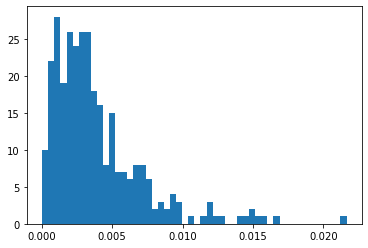

Median alpha: 3.046542e-03, Mean alpha: 3.891872e-03


In [9]:
alphas = [LassoLarsIC(fit_intercept=True).fit(factors_split_train, returns_split_train[col]).alpha_ for col in returns_split_train.columns]
plt.hist(alphas, bins=50)
plt.show()
print(f'Median alpha: {np.median(alphas):e}, Mean alpha: {np.mean(alphas):e}')

In [10]:
factor_model = ElasticNet(3e-3, fit_intercept=True).fit(factors_split_train, returns_split_train)
# factor_model = Lasso(3e-3, fit_intercept=False).fit(factors_split_train, returns_split_train)
# factor_model = LinearRegression(fit_intercept=False).fit(factors_split_train, returns_split_train)

In [11]:
train_residuals = returns_split_train - factor_model.predict(factors_split_train)
test_residuals = returns_split_test - factor_model.predict(factors_split_test)
(factor_model.coef_ != 0).mean()

0.7837108953613808

In [12]:
residuals_methods = ['returns', 'residuals']
spreads_methods = {
    ### Identity
    'Identity': compute_identity_L(),
    ### Top-k correlations
    # 'Corr-1': compute_corr_L(1),
    # 'Corr-5': compute_corr_L(5),
    # 'Corr-20': compute_corr_L(20),
    'Corr-50': compute_corr_L(50),
    ### Smooth graph signals
    # 'SGS laplacian_root=True, adjust_laplacian=True': compute_SGS_L(laplacian_root=True, adjust_laplacian=True),
    # 'SGS laplacian_root=True, adjust_laplacian=False': compute_SGS_L(laplacian_root=True, adjust_laplacian=False),
    # 'SGS laplacian_root=False, adjust_laplacian=True': compute_SGS_L(laplacian_root=False, adjust_laplacian=True),
    # 'SGS laplacian_root=False, adjust_laplacian=False': compute_SGS_L(laplacian_root=False, adjust_laplacian=False),
    ### Laplacian constrained gaussian markov random field
    # 'LGMRF laplacian_root=True, adjust_laplacian=True': compute_LGMRF_L(laplacian_root=True, adjust_laplacian=True),
    'LGMRF laplacian_root=True, adjust_laplacian=False': compute_LGMRF_L(laplacian_root=True, adjust_laplacian=False),
    # 'LGMRF laplacian_root=False, adjust_laplacian=True': compute_LGMRF_L(laplacian_root=False, adjust_laplacian=True),
    'LGMRF laplacian_root=False, adjust_laplacian=False': compute_LGMRF_L(laplacian_root=False, adjust_laplacian=False),
}

windows = [1] # [1, 2, 4, 12, 24]
quantiles = [.2] # [None, 0.1, 0.2]
gammas = [None] # [None, 2]
trading_type = ['long', 'short', 'both']
trading_methods = {f'Quantile-std w={_w} q={_q} gamma={_g} {_t_type}': quantiles_std_trading_rule(q=_q, w=_w, trading_type=_t_type, gamma=_g)
                        for _w, _q, _g, _t_type in itertools.product(windows, quantiles, gammas, trading_type) if not((_g==0) & (_q == 1))}

X, y = split_train(returns_factors_merged.index.values, numInputs=60, numOutputs=12+1, numJumps=1)
futures = client.map(lambda idx: evaluate_split_returns_from_idx(returns_factors_merged, factors.columns, idx_tuple=idx,
                                                                 residuals_method_names=residuals_methods, 
                                                                 spreads_methods=spreads_methods, 
                                                                 trading_methods=trading_methods), 
                     list(zip(X, y))[::12])
results = client.gather(futures)

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pand

In [13]:
split_returns_df = pd.concat(results)
# split_returns_df['compl_avg_month_returns'] = np.real(split_returns_df['compl_avg_month_returns'])
# split_returns_df['pairs_avg_month_returns'] = np.real(split_returns_df['pairs_avg_month_returns'])
split_returns_df['config'] = split_returns_df['residuals_method'] + ' - '+ split_returns_df['spreads_method'] + ' - ' + split_returns_df['trading_method']
split_returns_df['residuals_method_name'] = split_returns_df['residuals_method'].str.split(expand=True)[0]
split_returns_df['trading_method_name'] = split_returns_df['trading_method'].str.split(expand=True)[0]
split_returns_df['spreads_method_name'] = split_returns_df['spreads_method'].str.split(expand=True)[0]
split_returns_df['date'] = pd.to_datetime(split_returns_df['index'].str[:4] + '-' + split_returns_df['index'].str[4:] + '-01')
split_returns_df

,index,avg_month_returns,compl_avg_month_returns,pairs_avg_month_returns,n_positions_avg,n_positions_compl,n_positions_pair,benchmark,trading_method,spreads_method,residuals_method,config,residuals_method_name,trading_method_name,spreads_method_name,date
0,200002,0.188205,0.000000,0.094102,31,0,31,False,Quantile-std w=1 q=0.2 gamma=None long,Identity,returns,returns - Identity - Quantile-std w=1 q=0.2 ga...,returns,Quantile-std,Identity,2000-02-01
1,200003,0.014370,0.000000,0.007185,31,0,31,False,Quantile-std w=1 q=0.2 gamma=None long,Identity,returns,returns - Identity - Quantile-std w=1 q=0.2 ga...,returns,Quantile-std,Identity,2000-03-01
2,200004,-0.015883,0.000000,-0.007941,31,0,31,False,Quantile-std w=1 q=0.2 gamma=None long,Identity,returns,returns - Identity - Quantile-std w=1 q=0.2 ga...,returns,Quantile-std,Identity,2000-04-01
3,200005,-0.030880,0.000000,-0.015440,31,0,31,False,Quantile-std w=1 q=0.2 gamma=None long,Identity,returns,returns - Identity - Quantile-std w=1 q=0.2 ga...,returns,Quantile-std,Identity,2000-05-01
4,200006,0.076230,0.000000,0.038115,31,0,31,False,Quantile-std w=1 q=0.2 gamma=None long,Identity,returns,returns - Identity - Quantile-std w=1 q=0.2 ga...,returns,Quantile-std,Identity,2000-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,202109,0.072214,0.072214,0.072214,427,427,427,True,Quantile-std w=1 q=0.2 gamma=None both,"LGMRF laplacian_root=False, adjust_laplacian=F...",residuals,"residuals - LGMRF laplacian_root=False, adjust...",residuals,Quantile-std,LGMRF,2021-09-01
8,202110,-0.038809,-0.038809,-0.038809,427,427,427,True,Quantile-std w=1 q=0.2 gamma=None both,"LGMRF laplacian_root=False, adjust_laplacian=F...",residuals,"residuals - LGMRF laplacian_root=False, adjust...",residuals,Quantile-std,LGMRF,2021-10-01
9,202111,0.094384,0.094384,0.094384,427,427,427,True,Quantile-std w=1 q=0.2 gamma=None both,"LGMRF laplacian_root=False, adjust_laplacian=F...",residuals,"residuals - LGMRF laplacian_root=False, adjust...",residuals,Quantile-std,LGMRF,2021-11-01
10,202112,-0.064764,-0.064764,-0.064764,427,427,427,True,Quantile-std w=1 q=0.2 gamma=None both,"LGMRF laplacian_root=False, adjust_laplacian=F...",residuals,"residuals - LGMRF laplacian_root=False, adjust...",residuals,Quantile-std,LGMRF,2021-12-01


In [14]:
split_returns_df.to_pickle('data/results_sp500_prices.pkl')

In [17]:
split_returns_df_no_bench = split_returns_df[(split_returns_df['benchmark'] == False)].copy()
split_returns_df_no_bench['zero_return'] = split_returns_df_no_bench['avg_month_returns'] == 0
split_returns_df_no_bench
split_returns_df_no_bench.groupby('config')['zero_return'].all().sum(), split_returns_df_no_bench['config'].nunique()

224

In [ ]:
trading_returns_mean = trading_returns.mean().reset_index()
#trading_returns_mean = (trading_returns.mean() / trading_returns.std()).fillna(0).reset_index()
# trading_returns_mean = trading_alphas.reset_index().rename(columns={'alpha': 0})
trading_returns_mean[['data', 'graph', 'trading']] = trading_returns_mean['config'].str.split(' - ', expand=True)
trading_returns_mean[['trading', 'w', 'q', 'gamma', 'type']] = trading_returns_mean['trading'].str.split(' ', expand=True)
trading_returns_mean['w'] = trading_returns_mean['w'].str.split('=', expand=True)[1].astype(int)
trading_returns_mean['q'] = trading_returns_mean['q'].str.split('=', expand=True)[1].astype(float)
trading_returns_mean['gamma'] = trading_returns_mean['gamma'].str.split('=', expand=True)[1].astype(float)
trading_returns_mean['data'] = trading_returns_mean['data'].map(dict(zip(trading_returns_mean['data'].unique(), 
                                                                         range(trading_returns_mean['data'].nunique()))))
trading_returns_mean['graph'] = trading_returns_mean['graph'].map(dict(zip(trading_returns_mean['graph'].unique(), 
                                                                         range(trading_returns_mean['graph'].nunique()))))
trading_returns_mean['type'] = trading_returns_mean['type'].map(dict(zip(trading_returns_mean['type'].unique(), 
                                                                         range(trading_returns_mean['type'].nunique()))))
trading_returns_mean = trading_returns_mean.drop(columns=['config', 'trading']).rename(columns={0: 'mean'})
trading_returns_mean

In [ ]:
rf = RandomForestRegressor().fit(trading_returns_mean.iloc[:, 1:], trading_returns_mean.iloc[:, 0])
pd.Series(rf.feature_importances_, index=trading_returns_mean.iloc[:, 1:].columns).sort_values().plot.barh()
rf.score(trading_returns_mean.iloc[:, 1:], trading_returns_mean.iloc[:, 0]), rf.feature_importances_.sum()

In [ ]:
trading_returns = split_returns_df[split_returns_df['benchmark'] == False].pivot_table(values='avg_month_returns', columns='config', index='index')
# trading_returns = split_returns_df[split_returns_df['benchmark'] == False].pivot_table(values='compl_avg_month_returns', columns='config', index='index')
# trading_returns = split_returns_df[split_returns_df['benchmark'] == False].pivot_table(values='pairs_avg_month_returns', columns='config', index='index')
trading_returns *= np.sign(trading_returns.mean())
trading_returns
trading_returns.index = factors.loc[trading_returns.index[1]:].iloc[:len(trading_returns)].index
K = 5
top_mean_configs = trading_returns.mean().sort_values(ascending=False).iloc[:K].index.values
top_sharpe_configs = (trading_returns.mean() / trading_returns.std()).sort_values(ascending=False).iloc[:K].index.values

trading_returns_lm = LinearRegression(fit_intercept=True).fit(factors.loc[trading_returns.index], trading_returns)
trading_alphas = pd.Series(trading_returns_lm.intercept_, index=trading_returns.columns, name='alpha').sort_values(ascending=False)
top_alpha_configs = trading_alphas.iloc[:K].index.values
top_configs = set(top_mean_configs.tolist() + top_sharpe_configs.tolist() + top_alpha_configs.tolist())

In [2]:
# trading_alphas
# trading_returns
trading_returns.mean().sort_values(ascending=False).head()

NameError: name 'trading_returns' is not defined

In [3]:
trading_alphas_mean = trading_alphas.reset_index().set_index('config').copy()
trading_alphas_mean['mean'] = trading_returns.mean()
2 ** (trading_alphas_mean.sort_values('alpha', ascending=False).head(7) * 12) - 1
# trading_alphas_mean.sort_values('alpha', ascending=False).head(7)

NameError: name 'trading_alphas' is not defined

In [4]:
fig, axs =plt.subplots(3, figsize=(24, 24))
trading_returns[top_mean_configs].cumsum().plot(ax=axs[0])
split_returns_df[(split_returns_df['config'] == top_mean_configs[0]) & split_returns_df['benchmark']][['index', 'avg_month_returns']].set_index('index').rename(columns={'avg_month_returns': 'Benchmark'}).cumsum().plot(color='black', ls='--', ax=axs[0])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Cumulative Log2 Returns')
axs[0].set_title('Top-5 Mean Returns')
trading_returns[top_sharpe_configs].cumsum().plot(ax=axs[1])
split_returns_df[(split_returns_df['config'] == top_mean_configs[0]) & split_returns_df['benchmark']][['index', 'avg_month_returns']].set_index('index').rename(columns={'avg_month_returns': 'Benchmark'}).cumsum().plot(color='black', ls='--', ax=axs[1])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Cumulative Log2 Returns')
axs[1].set_title('Top-5 Sharpe Ratio')
trading_returns[top_alpha_configs].cumsum().plot(ax=axs[2])
split_returns_df[(split_returns_df['config'] == top_mean_configs[0]) & split_returns_df['benchmark']][['index', 'avg_month_returns']].set_index('index').rename(columns={'avg_month_returns': 'Benchmark'}).cumsum().plot(color='black', ls='--', ax=axs[2])
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Cumulative Log2 Returns')
axs[2].set_title('Top-5 alpha')
plt.show()

NameError: name 'plt' is not defined

In [39]:
idx_alpha, _ = split_train(trading_returns.index.values, numInputs=24, numOutputs=0, numJumps=1)
intercepts = []
for idx in idx_alpha:
    intercepts.append(LinearRegression(fit_intercept=True).fit(factors.loc[idx], trading_returns.loc[idx]).intercept_)

To have at least one X,y arrays, the sequence size needs to be bigger than numInputs+numOutputs


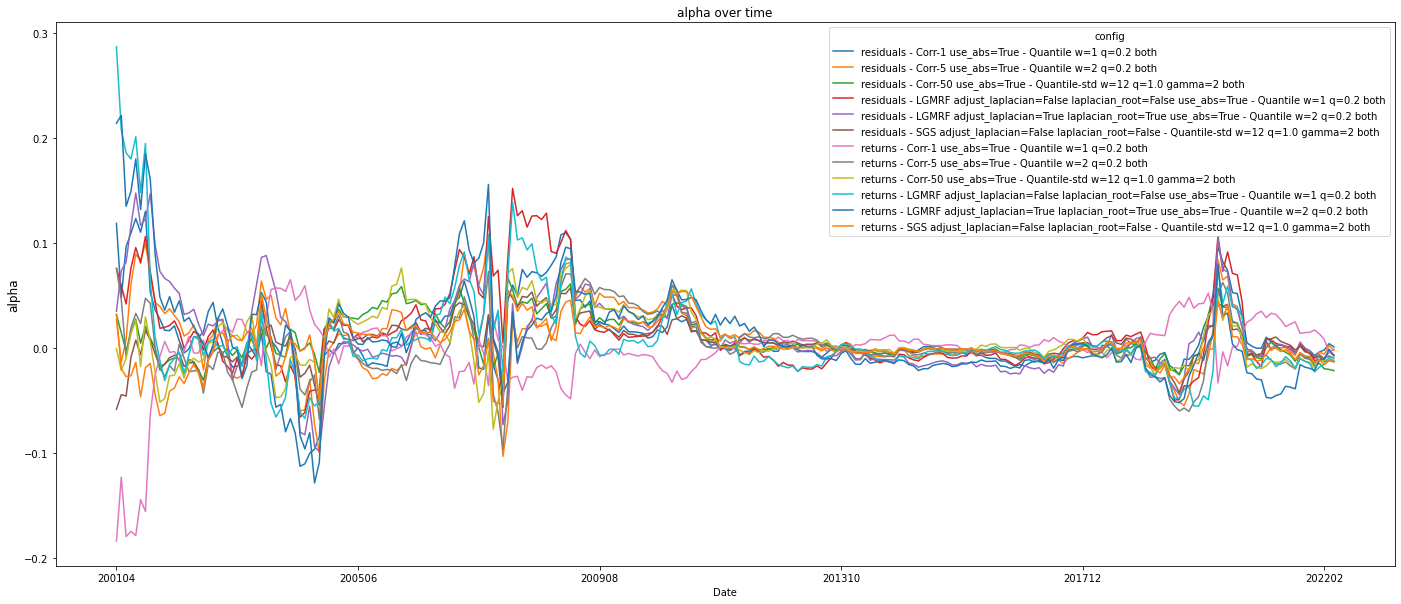

In [215]:
fig, ax =plt.subplots(figsize=(24, 10))
alpha_df = pd.DataFrame(np.array(intercepts), index=trading_returns.index[23:], columns=trading_returns.columns)
alpha_df.iloc[:, ::24].plot(ax=ax)
ax.set_title('alpha over time')
ax.set_ylabel('alpha', fontsize=12)
plt.show()

In [189]:
trading_returns.index[11:].shape

(265,)

In [185]:
len(idx_alpha)

NameError: name 'idx_alpha' is not defined

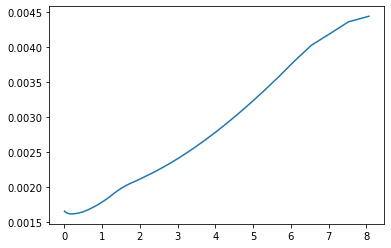

Best Alpha: 0.18636687003259295


,config,alpha
0,returns - SGS adjust_laplacian=True laplacian_...,0.005234
1,returns - Identity - Quantile-std w=2 q=1.0 ga...,0.004695
2,residuals - Corr-50 use_abs=True - Quantile-st...,0.004631
3,returns - Identity - Quantile w=12 q=0.2 both,0.004572
4,residuals - Corr-1 use_abs=True - Quantile-std...,0.004151
5,residuals - Identity - Quantile w=2 q=0.2 both,0.004013
6,residuals - Identity - Quantile w=1 q=0.2 both,0.003918
7,residuals - LGMRF adjust_laplacian=True laplac...,0.003755
8,residuals - LGMRF adjust_laplacian=True laplac...,0.003702
9,residuals - SGS adjust_laplacian=False laplaci...,0.003602


In [179]:
trading_returns_lm = MultiTaskElasticNetCV(fit_intercept=True).fit(factors.loc[trading_returns.index], trading_returns)
plt.plot(trading_returns_lm.alphas_, trading_returns_lm.mse_path_.mean(axis=-1))
plt.show()
best_alpha = trading_returns_lm.alphas_[trading_returns_lm.mse_path_.mean(axis=-1).argmin()]
print(f'Best Alpha: {best_alpha}')
trading_returns_lm = LinearRegression(fit_intercept=True).fit(factors.loc[trading_returns.index], trading_returns)
pd.Series(2**trading_returns_lm.intercept_ - 1, index=trading_returns.columns, name='alpha').sort_values(ascending=False).reset_index().drop_duplicates('alpha').head(15)

In [155]:
trading_returns_lm = LinearRegression(fit_intercept=True).fit(factors.loc[trading_returns.index], trading_returns)
# trading_returns_lm = ElasticNet(alpha = best_alpha, fit_intercept = True).fit(factors.loc[trading_returns.index], trading_returns)
# trading_returns_lm = Lasso(alpha = 0.185, fit_intercept = True).fit(factors.loc[trading_returns.index], trading_returns)
pd.Series(2**trading_returns_lm.intercept_ - 1, index=trading_returns.columns, name='alpha').sort_values(ascending=False).reset_index().drop_duplicates('alpha').head(15)

,config,alpha
0,residuals - Identity - Quantile-std w=2 q=1.0 ...,0.002641
1,residuals - Identity - Quantile w=1 q=0.5 both,0.002448
2,residuals - LGMRF adjust_laplacian=True laplac...,0.002018
3,residuals - Identity - Quantile w=2 q=0.2 both,0.002005
4,residuals - Identity - Quantile w=1 q=0.2 both,0.001957
5,residuals - LGMRF adjust_laplacian=True laplac...,0.001849
6,residuals - LGMRF adjust_laplacian=True laplac...,0.001835
7,residuals - Identity - Quantile w=2 q=0.5 both,0.001767
8,residuals - LGMRF adjust_laplacian=True laplac...,0.001613
9,residuals - Identity - Quantile-std w=12 q=1.0...,0.001581


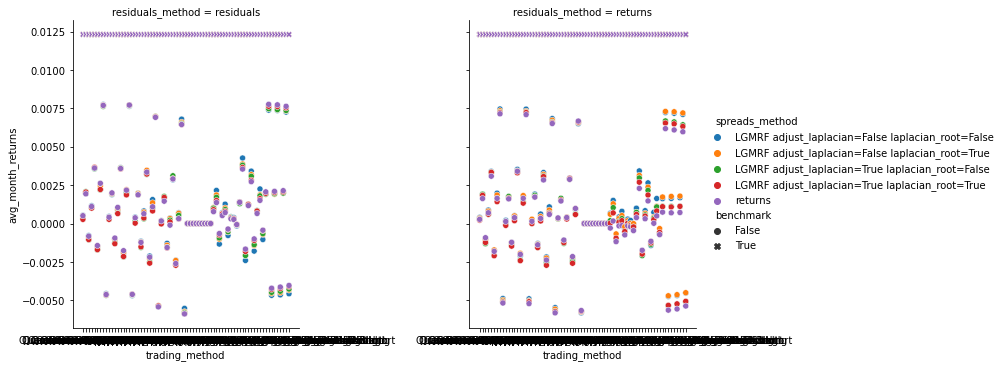

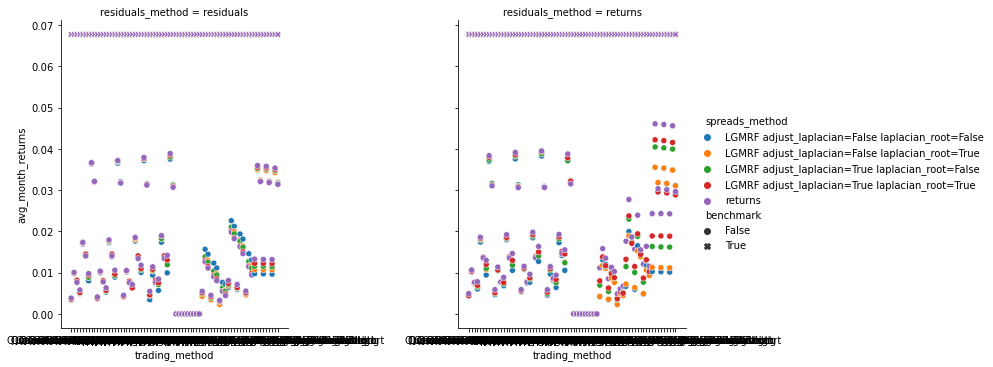

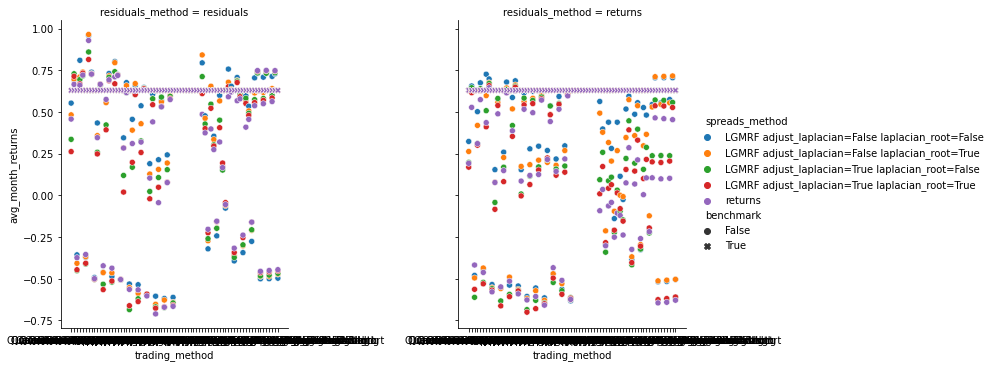

In [254]:
grouped_split_results = split_returns_df.groupby(['trading_method', 'spreads_method', 'residuals_method', 'benchmark'])['avg_month_returns']
# fig, axs = plt.subplots(3, figsize=(16, 15))

sns.relplot(data=(grouped_split_results.mean()).reset_index(),
            x='trading_method', y='avg_month_returns', style='benchmark', # hue='benchmark', 
            hue='spreads_method', col='residuals_method', kind='scatter')
plt.show()
sns.relplot(data=(grouped_split_results.std()).reset_index(),
            x='trading_method', y='avg_month_returns', style='benchmark', # hue='benchmark', 
            hue='spreads_method', col='residuals_method', kind='scatter')
plt.show()
sns.relplot(data=(grouped_split_results.mean() / grouped_split_results.std() * np.sqrt(12)).reset_index(),
            x='trading_method', y='avg_month_returns', style='benchmark', # hue='benchmark',
            hue='spreads_method', col='residuals_method', kind='scatter')
plt.show()

<AxesSubplot:ylabel='config'>

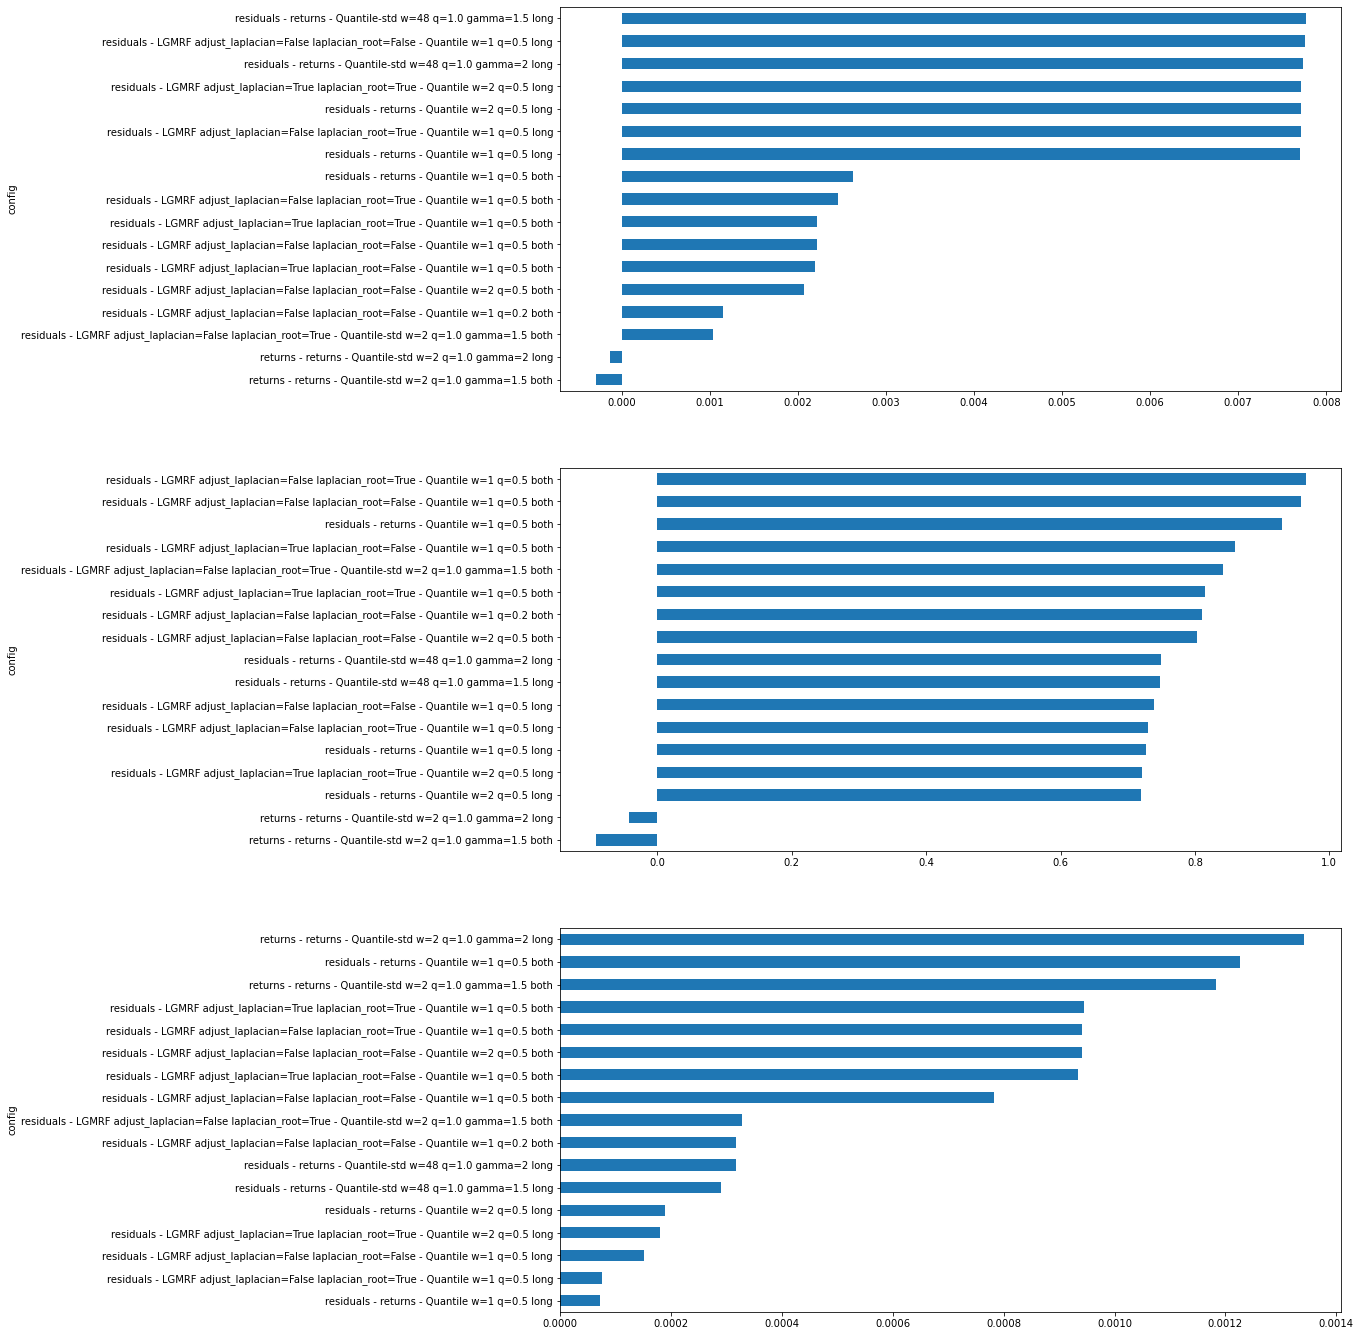

In [255]:
fig, axs = plt.subplots(3, figsize=(14, 24))
grouped_split_results = split_returns_df[split_returns_df['config'].isin(top_configs) & (split_returns_df['benchmark'] == False)].groupby('config')['avg_month_returns']
grouped_split_results.mean().sort_values(ascending=True).plot.barh(x='config', y='avg_month_returns', ax=axs[0])
(grouped_split_results.mean() / grouped_split_results.std() * np.sqrt(12)).sort_values(ascending=True).plot.barh(x='config', y='avg_month_returns', ax=axs[1])
trading_alphas[top_configs].sort_values(ascending=True).plot.barh(ax=axs[2])

In [ ]:
split_results_df = pd.concat(split_results_list)
split_results_df['date'] = pd.to_datetime(split_results_df['date'].str[:4] + '-' + split_results_df['date'].str[4:] + '-01')
split_results_df['window'] = split_results_df['w'].astype(str)
split_results_df['quantile'] = split_results_df['q'].astype(str)
split_results_df['index'] += 1
# split_results_df = split_results_df[(split_results_df['w'] != 24).values]
split_results_df

In [ ]:
mean_split_results_df = split_results_df.groupby(['date', 'q', 'w', 'trading_type', 'benchmark'])['avg_month_returns'].mean().reset_index()
clean_split_results_df = []
for i, g in mean_split_results_df.groupby(['q', 'w', 'trading_type', 'benchmark']):
    g = g.sort_values('date')
    g['cumulative_monthly_returns'] = g['avg_month_returns'].cumsum()
    clean_split_results_df.append(g)
clean_split_results_df = pd.concat(clean_split_results_df)
clean_split_results_df

In [ ]:
set(['a', 'a', 'b', 'c', 'b'])

In [ ]:
sns.relplot(data=clean_split_results_df, x='date', y='cumulative_monthly_returns', 
            hue='trading_type', style='benchmark', 
            row='w', col='q', kind='line', height=3, aspect=3)
plt.show()

In [ ]:
sns.relplot(data=clean_split_results_df, x='w', y='avg_month_returns', 
            row='trading_type', col='q', 
            hue='benchmark', kind='line', height=3, aspect=2)
plt.show()

In [ ]:
grouped_split_results = clean_split_results_df.groupby(['q', 'w', 'trading_type', 'benchmark'])['avg_month_returns']
# fig, axs = plt.subplots(3, figsize=(16, 15))

sns.relplot(data=(grouped_split_results.mean()).reset_index(),
                x='w', y='avg_month_returns', hue='q', col='trading_type', style='benchmark', palette='husl', kind='line')
plt.show()
sns.relplot(data=(grouped_split_results.std()).reset_index(),
                x='w', y='avg_month_returns', hue='q', col='trading_type', style='benchmark', palette='husl', kind='line')
plt.show()
sns.relplot(data=(grouped_split_results.mean() / grouped_split_results.std() * np.sqrt(12)).reset_index(),
                x='w', y='avg_month_returns', hue='q', col='trading_type', style='benchmark', palette='husl', kind='line')
plt.show()

In [ ]:
# %%time
# train_spreads, test_spreads, L, L_sqrt = compute_spreads(train_residuals, test_residuals, laplacian_root=False, reltol=2.5e-4)
# pd.DataFrame({'train': np.abs(np.sign(train_spreads.cumsum()).diff() / 2).sum().round(), 
#               'test': np.abs(np.sign(test_spreads.cumsum()).diff() / 2).sum().round()}).plot.hist(bins=40, alpha=.4)
# pd.DataFrame({'train': np.abs(np.sign(train_spreads.cumsum()).diff() / 2).sum().round(), 
#               'test': np.abs(np.sign(test_spreads.cumsum()).diff() / 2).sum().round()}).mean()